In [1]:
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(palette="bright")
import tqdm

import jax.numpy as np
from jax import jit, lax, random
from jax.config import config; config.update("jax_platform_name", "cpu")
from jax.scipy.special import logsumexp

import numpyro.distributions as dist
from numpyro.handlers import sample
from numpyro.hmc_util import initialize_model
from numpyro.mcmc import hmc
from numpyro.util import fori_collect

In [2]:
def simulate_data(rng, num_categories, num_words, num_supervised_data, num_unsupervised_data):
    rng, rng_transition, rng_emission = random.split(rng, 3)

    transition_prior = np.ones(num_categories)
    emission_prior = np.repeat(0.1, num_words)

    transition_prob = dist.Dirichlet(transition_prior).sample(key=rng_transition,
                                                              size=(num_categories,))
    emission_prob = dist.Dirichlet(emission_prior).sample(key=rng_emission, size=(num_categories,))

    start_prob = np.repeat(1. / num_categories, num_categories)
    categories, words = [], []
    for t in range(num_supervised_data + num_unsupervised_data):
        rng, rng_transition, rng_emission = random.split(rng, 3)
        if t == 0 or t == num_supervised_data:
            category = dist.Categorical(start_prob).sample(key=rng_transition)
        else:
            category = dist.Categorical(transition_prob[category]).sample(key=rng_transition)
        word = dist.Categorical(emission_prob[category]).sample(key=rng_emission)
        categories.append(category)
        words.append(word)

    # split into supervised data and unsupervised data
    categories, words = np.stack(categories), np.stack(words)
    supervised_categories = categories[:num_supervised_data]
    supervised_words = words[:num_supervised_data]
    unsupervised_words = words[num_supervised_data:]
    return (transition_prior, emission_prior, transition_prob, emission_prob,
            supervised_categories, supervised_words, unsupervised_words)

In [3]:
(transition_prior, emission_prior,
 transition_prob, emission_prob,
 supervised_categories,
 supervised_words,
 unsupervised_words) = simulate_data(random.PRNGKey(1),
                                     num_categories=3,
                                     num_words=10,
                                     num_supervised_data=100,
                                     num_unsupervised_data=500)

### NumPyro

In [4]:
def forward_one_step(prev_log_prob, curr_word, transition_log_prob, emission_log_prob):
    log_prob_tmp = np.expand_dims(prev_log_prob, axis=1) + transition_log_prob
    log_prob = log_prob_tmp + emission_log_prob[:, curr_word]
    return logsumexp(log_prob, axis=0)

naive implementaion

```python
def forward_log_prob(init_log_prob, words, transition_lob_prob, emission_log_prob):
    log_prob = init_log_prob
    for word in words:
        log_prob = forward_one_step(log_prob, word, transition_log_prob, emission_log_prob)
    return log_prob
```

In [5]:
def forward_log_prob(init_log_prob, words, transition_lob_prob, emission_log_prob):
    def scan_fn(log_prob, word):
        return forward_one_step(log_prob, word, transition_lob_prob, emission_log_prob), np.ones(())

    log_prob, _ = lax.scan(scan_fn, init_log_prob, words)
    return log_prob

In [6]:
def semi_supervised_hmm(supervised_categories, supervised_words, unsupervised_words):
    num_categories, num_words = transition_prior.shape[0], emission_prior.shape[0]
    transition_prob = sample("transition_prob", dist.Dirichlet(
        np.broadcast_to(transition_prior, (num_categories, num_categories))))
    emission_prob = sample("emission_prob", dist.Dirichlet(
        np.broadcast_to(emission_prior, (num_categories, num_words))))

    sample("supervised_categories", dist.Categorical(transition_prob[supervised_categories[:-1]]),
           obs=supervised_categories[1:])
    sample("supervised_words", dist.Categorical(emission_prob[supervised_categories]),
           obs=supervised_words)

    transition_log_prob = np.log(transition_prob)
    emission_log_prob = np.log(emission_prob)
    init_log_prob = emission_log_prob[:, unsupervised_words[0]]
    log_prob = forward_log_prob(init_log_prob, unsupervised_words[1:],
                                transition_log_prob, emission_log_prob)
    # inject log_prob to potential function
    return sample("forward_log_prob", dist.Multinomial(logits=log_prob), obs=0)

In [7]:
init_params, potential_fn, transform_fn = initialize_model(
    random.PRNGKey(2), semi_supervised_hmm,
    (supervised_categories, supervised_words, unsupervised_words), {})
init_kernel, sample_kernel = hmc(potential_fn, algo="NUTS")

hmc_state, wa_state, warmup_update = init_kernel(init_params, num_warmup_steps=100,
                                                 run_warmup=False)

In [8]:
start = time.time()
warmup_update(0, (hmc_state.update(step_size=10.), wa_state))
print("time to compile sample_kernel and wa_update:", time.time() - start)

time to compile sample_kernel and wa_update: 20.8685622215271


In [9]:
for t in tqdm.trange(100):
    hmc_state, wa_state = warmup_update(t, (hmc_state, wa_state))

100%|██████████| 100/100 [00:08<00:00, 11.82it/s]


In [10]:
hmc_states = fori_collect(100, sample_kernel, hmc_state,
                          transform=lambda state: {
                              "transition_prob": transform_fn(state.z)["transition_prob"],
                              "num_steps": state.num_steps,
                          })

100%|██████████| 100/100 [00:09<00:00, 10.38it/s]


In [11]:
print(hmc_states["num_steps"].copy())

[1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023
 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023
 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023
 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023
 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023
 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023
 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023
 1023 1023]


### Stan

In [17]:
import urllib

import pystan

url = "https://raw.githubusercontent.com/stan-dev/example-models/master/misc/hmm/hmm-semisup.stan"
stan_model = urllib.request.urlopen(url).read().decode("utf-8")
print(stan_model)

data {
  int<lower=1> K;  // num categories
  int<lower=1> V;  // num words
  int<lower=0> T;  // num supervised items
  int<lower=1> T_unsup;  // num unsupervised items
  int<lower=1,upper=V> w[T]; // words
  int<lower=1,upper=K> z[T]; // categories
  int<lower=1,upper=V> u[T_unsup]; // unsup words
  vector<lower=0>[K] alpha;  // transit prior
  vector<lower=0>[V] beta;   // emit prior
}
parameters {
  simplex[K] theta[K];  // transit probs
  simplex[V] phi[K];    // emit probs
}
model {
  for (k in 1:K) 
    theta[k] ~ dirichlet(alpha);
  for (k in 1:K)
    phi[k] ~ dirichlet(beta);
  for (t in 1:T)
    w[t] ~ categorical(phi[z[t]]);
  for (t in 2:T)
    z[t] ~ categorical(theta[z[t-1]]);

  { 
    // forward algorithm computes log p(u|...)
    real acc[K];
    real gamma[T_unsup,K];
    for (k in 1:K)
      gamma[1,k] <- log(phi[k,u[1]]);
    for (t in 2:T_unsup) {
      for (k in 1:K) {
        for (j in 1:K)
          acc[j] <- gamma[t-1,j] + log(theta[j,k]) + log(phi[k,u[t]]);
  

In [18]:
%%time
model = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_14c781acf8dbbaa6f89d694cd310dd75 NOW.


CPU times: user 1.01 s, sys: 64 ms, total: 1.08 s
Wall time: 49.5 s


In [14]:
%%time
data = {"K": transition_prior.shape[0], "V": emission_prior.shape[0],
        "T": supervised_words.shape[0], "T_unsup": unsupervised_words.shape[0],
        "alpha": transition_prior, "beta": emission_prior,
        "w": supervised_words + 1, "z": supervised_categories + 1, "u": unsupervised_words + 1}
fit = model.sampling(data, chains=1, iter=200)

CPU times: user 22.7 s, sys: 36 ms, total: 22.8 s
Wall time: 22.7 s


In [15]:
fit.get_sampler_params()[0]["n_leapfrog__"][100:]

array([127., 127., 127., 255., 127., 127., 255., 127., 255., 255., 255.,
       127., 255., 127., 255., 127., 255., 319., 255., 255., 255., 127.,
       255., 255., 255., 255., 127., 255., 255., 127., 255., 255., 255.,
       127., 127., 127., 255., 255., 255., 383., 127., 127., 255., 255.,
       255., 255., 255., 383., 127., 255., 255., 255., 255., 255.,  96.,
       255., 127., 255., 255., 127., 255., 127., 255., 447., 127., 127.,
       127., 127., 255., 255., 235., 127., 127., 255., 255., 127., 255.,
       127., 191., 127., 127., 255., 255., 127., 255., 127., 191.,  63.,
       127.,  94., 255., 127., 255., 203., 255., 255., 127., 127., 255.,
       255.])

### Plot

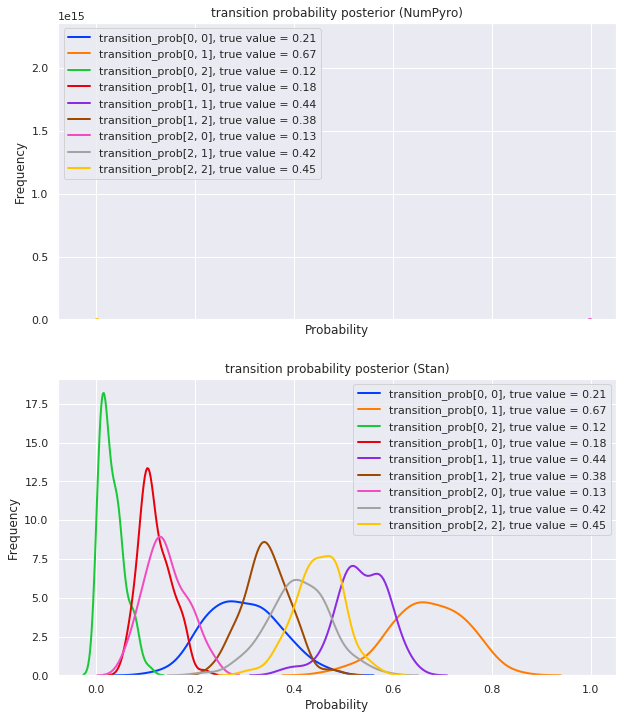

In [16]:
def plot(ax, transition_prob_posterior, title):
    for i in range(transition_prob.shape[0]):
        for j in range(transition_prob.shape[1]):
            sns.distplot(transition_prob_posterior[:, i, j], hist=False, kde_kws={"lw": 2},
                         label="transition_prob[{}, {}], true value = {:.2f}"
                         .format(i, j, transition_prob[i, j]), ax=ax)
    ax.set(xlabel="Probability", ylabel="Frequency",
           title="transition probability posterior ({})".format(title))

_, (ax1, ax2) = plt.subplots(2, figsize=(10, 12), sharex=True)
plot(ax1, hmc_states["transition_prob"], "NumPyro")
plot(ax2, np.array(fit.extract(pars="theta")["theta"]), "Stan")